Reconstruct a single, upsampled high resolution image from a series of low resolution images using Fourier ptychography.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
import numpy as np
import cv2
# from skimage.exposure import match_histograms
import fpm_functions as fpm

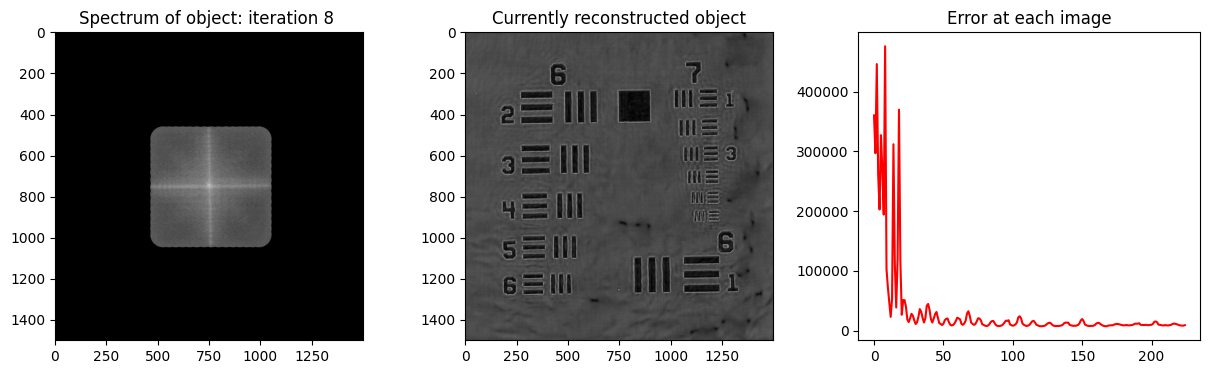


 Reconstruction Done!


In [11]:
# Main FPM reconstruction. Set up for square, grayscale images
import importlib 
importlib.reload(fpm)

# Load image data into an array
data_path = 'data/library/usaf_v3_58'
grid_size = 15 # 1 -> 15, determines how many images to reconstruct with
crop_x=crop_y = 0
img_size = 300

# Optical parameters
# LED2SAMPLE # Distance from LED array to the sample
# LED_P # LED pitch, 3.3mm
# NA # Objective numerical aperture, 0.1
# PIX_SIZE # Pixel size on object plane
# WLENGTH # Central wavelength of LED light, 550nm for white or green, 630nm for red, 460nm for blue
# x_initial # x distance from first LED to optical axis, (+ve if first LED is to right of optical axis)
# y_initial # y distance from first LED to optical axis, (+ve if first LED is above optical axis)

LED2SAMPLE = 58
x_initial = 0.9
y_initial = -0.5
LED_P = 3.3
NA = 0.1
PIX_SIZE = 1150e-9 # 1150 for 3x, 725 for new (measured), 850 for 4x (expected)
WLENGTH = 550e-9

num_images = grid_size**2
images = np.zeros((img_size,img_size,num_images)) # Initialise array for storing images
brightfield = np.array(Image.open(os.path.join(data_path,'brightfield.png')))/255 # Brightfield image for reference
brightfield = brightfield[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop

for i in range(num_images): # ~ 2s to load all 256 images into array
    filename = os.path.join(data_path, f'image_{i}.png') # Construct path
    img = np.array(Image.open(filename),dtype=np.int16) # Open image as numpy array
    img = img[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop
    # img = np.clip(img-1,0,255) # Background baseline removal (not recommended)
    # Denoising basically crops out the far darkfield images which are almost empty anyway
    # img = cv2.fastNlMeansDenoising(img,None,1,7,21)/255 # Denoise (not recommended)
    images[:,:,i] = img

# LED sequence
x_coords, y_coords = fpm.LED_spiral(grid_size)


# Derived variables
F_CUTOFF = 2*NA/WLENGTH # Highest spatial frequency we can resolve in the optical system due to diffraction, lp/m
F_SAMPLING = 1/PIX_SIZE # Sampling frequency (based on sensor pixel size and magnification), lp/m
# Nyquist sampling criterion: sampling_ratio >2 -> oversampling (good), sampling_ratio <2 -> undersampling (aliasing may occur)
SAMPLING_RATIO = F_SAMPLING / F_CUTOFF # Ensure above 2
# print(f'Sampling ratio: {SAMPLING_RATIO}')
# img_size * PIX_SIZE is the total object size in spacial domain (~300um)
sampling_size = 1/(img_size*PIX_SIZE) # Sampling size in the Fourier domain (used to scale wavevectors for indexing)
x_abs = (x_coords - x_coords[0]) * LED_P + x_initial # x distances of LEDs from optical axis, mm
y_abs = (y_coords - y_coords[0]) * LED_P + y_initial # y distances 

# Size of reconstructed image (for given parameters upsampling is between 2 and 5 depending on grid_size)
# Can do seperately x and y if image is not square
# upsampling_ratio = fpm.calculate_upsampling_ratio(img_size, grid_size, LED2SAMPLE, LED_P, NA, WLENGTH, sampling_size)
upsampling_ratio = 5 # Or can use a set value, recommended 5
obj_size = upsampling_ratio * img_size

# LED wavevectors - scaled for indexing in Fourier domain. To get true wavevectors multiply by sampling size * 2pi
kx,ky = fpm.calculate_wavevectors(x_abs, y_abs, LED2SAMPLE, WLENGTH, sampling_size)

# Initial pupil function (binary mask)
# x,y is our normalised frequency domain for the images, cutoff frequency = 1 (both x and y)
x,y = np.meshgrid(np.linspace(-SAMPLING_RATIO,SAMPLING_RATIO,img_size), np.linspace(-SAMPLING_RATIO,SAMPLING_RATIO,img_size))
theta,r = np.arctan2(y,x), np.sqrt(x**2 + y**2) # Polar coordinates
# pupil_radius = (1/SAMPLING_RATIO) * (img_size/2) # In pixels
# pupil_radius = NA/WLENGTH * img_size * PIX_SIZE
pupil_binary = r<1 # Binary mask for frequencies below cutoff frequency (higher frequencies cannot be resolved due to diffraction)

# Initial object estimate (using central image or brightfield)
img = np.sqrt(images[:,:,0]) # Amplitude of central image
# img = np.sqrt(brightfield) # Amplitude of brightfield
F_img = fpm.FT(img) # Fourier transformed image
F_img = F_img * pupil_binary # Apply pupil function
pad_width = int((obj_size - img_size) / 2) # Padding to make correct size
obj = np.pad(F_img,pad_width,'constant',constant_values=0) # Initial object in spacial frequency (Fourier domain)

# Create fig and axes for plotting
fig, axes = plt.subplots(1,3,figsize=(15,4))

# Set parameters for reconstruction algorithm
options = {
    'max_iter': 8, # Number of iterations
    'alpha': 1, # Regularisation parameter for object update
    'beta': 1, # Regularisation parameter for pupil update
    'plot_mode': 3, # 0, off; 2, plot every image; 3, plot every iteration (notebook version)
    'LED_correction': 0, # 0, off; 1, accurate; 2, fast; 3, first iteration only
    'update_method': 2, # 1, PIE; 2, ePIE; 3, rPIE
    'momentum': False, # Use momentum on alpha and beta (tuned for ePIE only)
    'intensity_correction': True, # Adjust image intensity to account for LED variation
}

# Reconstruction with calculated kx and ky (quickstart)
rec_obj,rec_pupil,kx_updated,ky_updated = fpm.reconstruct(images, kx, ky, obj, pupil_binary, options, fig, axes, pupil=None)

# rec_obj,rec_pupil,kx_updated,ky_updated = fpm.reconstruct(images, kx_updated, ky_updated, obj, pupil_binary, options, fig, axes, pupil=None)

Plotting and save results

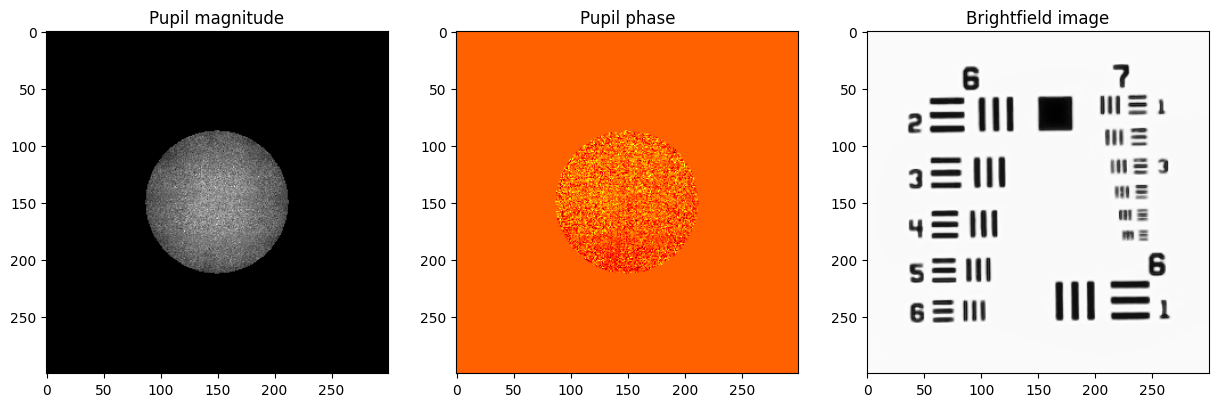

In [12]:
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15,15))

# Recovered object
obj_mag = np.abs(rec_obj) # Magnitude
obj_arg = np.angle(rec_obj) # Phase (-pi,pi)

# Recovered pupil
pupil_mag = np.abs(rec_pupil)
pupil_arg = np.angle(rec_pupil)

# # Show object
# axes[0].imshow(obj_mag,cmap='gray')
# axes[0].set_title('Object magnitude')
# axes[1].imshow(obj_arg, cmap='gray') # Heatmap for phase information
# axes[1].set_title('Object phase')

# Show pupil
axes[0].imshow(pupil_mag,cmap='gray')
axes[0].set_title('Pupil magnitude')
axes[1].imshow(pupil_arg, cmap='hot') # Heatmap for phase information
axes[1].set_title('Pupil phase')
# circle = patches.Circle((img_size//2,img_size//2),radius=pupil_radius,linewidth =0.5, edgecolor='red',facecolor='none')
# axes[0].add_patch(circle) # Ensure pupil radius is correct

# Show brighfield
axes[2].imshow(brightfield, cmap='gray')
axes[2].set_title('Brightfield image')

# Save results

# # Histogram matched image
# img_eq = match_histograms(obj_mag,brightfield)
# img_eq = img_eq - np.min(img_eq)
# img_eq = img_eq / np.max(img_eq)
# img_eq = (img_eq * 255).astype(np.uint8)
# img_eq = Image.fromarray(img_eq)
# img_eq.save('results/recent/magnitude_eq.png')

obj_mag = obj_mag - np.min(obj_mag)
obj_mag = obj_mag / np.max(obj_mag) # Convert to 0-1
obj_mag = (obj_mag * 255).astype(np.uint8) # Convert to 0-255 and uint8
# print(np.min(obj_mag),np.max(obj_mag))
obj_mag = Image.fromarray(obj_mag)
obj_mag.save('results/recent/magnitude.png')

obj_arg = obj_arg - np.min(obj_arg)
obj_arg = obj_arg / np.max(obj_arg)
obj_arg = (obj_arg * 255).astype(np.uint8)
# print(np.min(obj_arg),np.max(obj_arg))
obj_arg = Image.fromarray(obj_arg)
obj_arg.save('results/recent/phase.png')

bf = Image.open(os.path.join(data_path,'brightfield.png'))
bf.save('results/recent/brightfield.png')


Testing zone and utilities

Text(0.5, 1.0, 'Updated and original wavevectors')

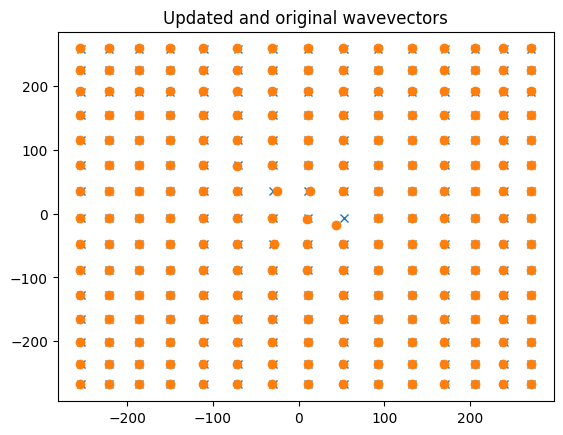

In [21]:
import importlib 
importlib.reload(fpm)

# Compare updated wavevectors to original wavevectors
kx,ky = fpm.calculate_wavevectors(x_abs,y_abs,LED2SAMPLE,WLENGTH,sampling_size)
plt.plot(kx,ky,'x') # Original LED positions
plt.plot(kx_updated,ky_updated,'o') # Corrected LED positions
plt.title('Updated and original wavevectors')

######################
# Show LED positions and calculate overlaps

# fig,ax = plt.subplots(1,1)

# # LED_P = 4 # Laura's
# # LED2SAMPLE = 90

# LED_P = 3.3
# LED2SAMPLE = 70


# x_coords, y_coords = fpm.LED_spiral(15)
# x_abs = (x_coords - x_coords[0]) * LED_P # x distances of LEDs from optical axis, mm
# y_abs = (y_coords - y_coords[0]) * LED_P # y distances 

# # Normal wavevectors
# kx,ky = fpm.calculate_wavevectors(x_abs, y_abs, LED2SAMPLE, WLENGTH, sampling_size)
# ax.plot(kx,ky,'x') # Original LED positions

# # Add circles for kx and ky
# circle1 = patches.Circle((kx[-1], ky[-1]), pupil_radius, color='red', fill=False)
# circle2 = patches.Circle((kx[-2], ky[-2]), pupil_radius, color='red', fill=False)
# circle3 = patches.Circle((kx[0], ky[0]), pupil_radius, color='red', fill=False)
# circle4 = patches.Circle((kx[1], ky[1]), pupil_radius, color='red', fill=False)

# # Add circles to the plot
# for circle in [circle1, circle2, circle3, circle4]:
#     ax.add_patch(circle)
    
# # Calculate overlaps
# r = pupil_radius
# d = np.abs(kx[-1]-kx[-2]) # Separation (x)
# overlap_area = (2 * r**2 * np.arccos(d / (2 * r))) - (d / 2 * np.sqrt(4 * r**2 - d**2))
# overlap_percent = overlap_area / (np.pi * r**2)
# print(f'Overlap edge: {overlap_percent*100}%')

# d = np.abs(kx[0]-kx[1]) # Separation (x)
# overlap_area = (2 * r**2 * np.arccos(d / (2 * r))) - (d / 2 * np.sqrt(4 * r**2 - d**2))
# overlap_percent = overlap_area / (np.pi * r**2)
# print(f'Overlap center: {overlap_percent*100}%')

# ax.set_aspect('equal')
# ax.set_title('LED positions in Fourier domain')

################################
# # Plot and inspect an image
# from scipy.io import loadmat

# i = 217
# img = np.array(Image.open(f'data/library/usaf_v3_NEW/image_{i}.png'))
# fig, axes = plt.subplots(1, 2, figsize=(15,15))
# # axes[0].imshow(np.log(np.abs(fpm.FT(img)) + 1), cmap='gray') # Show FT with log scale
# # axes[1].imshow(img/np.max(img), cmap='gray') # Normalised image
# axes[0].imshow(img, cmap='gray') # Regular image
# print(np.max(img),np.min(img)) # Dynamic range of image

# img2 = np.array(Image.open(f'data/library/usaf_v3_NEW_2/image_{i}.png'))
# axes[1].imshow(img2, cmap='gray')
# print(np.max(img2),np.min(img2)) # Dynamic range of image

# img3 = np.array(Image.open(f'data/library/usaf_v3_47_taped/image_{i}.png'))
# # img1 = cv2.fastNlMeansDenoising(img1,None,1,7,21)
# axes[1].imshow(img3, cmap='gray')
# print(np.max(img3),np.min(img3)) # Dynamic range of image

# data = loadmat('matlab_data/USAF_red.mat')
# images = data['imlow_HDR']  # Assuming 'imlow_HDR' key exists in the .mat file
# img2 = images[:,:,i]
# axes[2].imshow(img2, cmap='gray')


####################
# Histogram
# from skimage.exposure import match_histograms

# fig, axes = plt.subplots(1, 2, figsize=(15,15))
# img = np.array(Image.open('results/recent/magnitude.png'))
# ref = np.array(Image.open('results/recent/brightfield.png'))
# img_eq = match_histograms(img,ref)

# axes[0].imshow(img,cmap='gray')
# axes[1].imshow(img_eq,cmap='gray')

# img_eq = img_eq - np.min(img_eq)
# img_eq = img_eq / np.max(img_eq)
# img_eq = (img_eq * 255).astype(np.uint8)
# img_eq = Image.fromarray(img_eq)
# img_eq.save('results/recent/magnitude_eq.png')


#################################
# # Plot dynamic range vs image number
# img_ranges = np.zeros(num_images)
# for i in range(num_images):
#     img = images[:50,:50,i]
#     img_ranges[i] = (np.max(img) - np.min(img))*256
#     # img_ranges[i] = np.std(img)*1000
# plt.plot(img_ranges, label='image range - small crop')
# plt.xlabel('Image number')
# img_ranges = np.zeros(num_images)
# for i in range(num_images):
#     img = images[:,:,i]
#     img_ranges[i] = (np.max(img) - np.min(img))*256
#     # img_ranges[i] = np.std(img)*1000
# plt.plot(img_ranges, label='image range - large crop')
# # plt.axhline(np.min(img_ranges)*5)
# plt.xlabel('Image number')
# plt.legend()
# plt.show()

# # Dynamic range heat map
# threshold = 30 # Set to 0 to see every image in heatmap
# # Initialize dynamic ranges and define a 2D grid size based on your x, y locations
# img_ranges = np.zeros(num_images)
# for i in range(num_images):
#     img = images[:, :, i]
#     max_val = np.max(img) * 256
#     min_val = np.min(img) * 256
#     img_ranges[i] = max_val - min_val  # Store the dynamic range for each image
# # Create a 2D heatmap based on x, y coordinates
# heatmap = np.zeros((np.max(y_coords)+1, np.max(x_coords)+1))
# good_images = np.zeros(num_images) # At most will have num_images good images
# for i in range(num_images):
#     if img_ranges[i] >= threshold:
#         heatmap[y_coords[i], x_coords[i]] = img_ranges[i]  # Assign the dynamic range value at (x, y)
#         good_images[i] = i # Remember image number
#     else:
#         good_images[i] = None # Use none to avoid ambiguity with 0
# print(good_images)   
# # Plot the heatmap
# plt.imshow(heatmap, cmap='hot', origin='lower')
# plt.colorbar(label='Dynamic Range')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Dynamic Range Heatmap')
# plt.show()

Spectrum analysis

Text(0.5, 1.0, 'Entire spectrum')

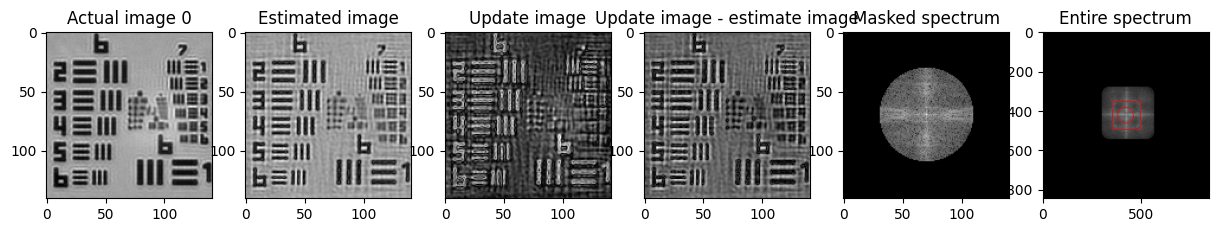

In [256]:
i = 0

img_size = images.shape[0] # Square, same size as pupil function
obj_size = obj.shape[0] # Square
obj_center = obj_size // 2
x_start = int(obj_center + (kx[i] - 0) - img_size//2) # For cropping object spectrum
y_start = int(obj_center - (ky[i] - 0) - img_size//2)  

# print(x_start,y_start)

# Part of spectrum to update
object_cropped = obj[y_start:y_start+img_size, x_start:x_start+img_size]
masked_object = object_cropped * pupil_binary

# Estimated image in Fourier domain
estimated_image = object_cropped * pupil_binary
# estimated_image = np.copy(object_cropped)

# Update image in Fourier domain
# update_image = fpm.FT(img * (fpm.IFT(estimated_image) / np.abs(fpm.IFT(estimated_image)))) - estimated_image # EPRY paper
update_image = fpm.FT(img*np.exp(1j*np.angle(fpm.IFT(estimated_image)))) - estimated_image # Identical

fig, axes = plt.subplots(1, 6, figsize=(15,15))
axes[0].imshow(np.abs(images[:,:,i]),cmap='gray')
axes[0].set_title(f'Actual image {i}')

axes[1].imshow(np.abs(fpm.IFT(estimated_image)),cmap='gray')
axes[1].set_title('Estimated image')

axes[2].imshow(np.abs(fpm.IFT(update_image)),cmap='gray')
axes[2].set_title('Update image')

axes[3].imshow(np.abs(fpm.IFT((update_image - estimated_image))),cmap='gray')
axes[3].set_title('Update image - estimate image')

# Masked spectrum
axes[4].imshow(np.log(np.abs(masked_object) + 1),cmap='gray')
axes[4].set_title('Masked spectrum')

# Whole spectrum
axes[5].imshow(np.log(np.abs(obj) + 1),cmap='gray')
rectangle = patches.Rectangle((x_start,y_start),img_size,img_size,linewidth=0.5, edgecolor='red', facecolor='none')
circle = patches.Circle((x_start + img_size//2, y_start + img_size//2), radius=pupil_radius,linewidth =0.5, edgecolor='red',facecolor='none')
axes[5].add_patch(circle)
axes[5].add_patch(rectangle)
axes[5].set_title('Entire spectrum')




For handling .mat dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

import importlib 
importlib.reload(fpm)

data = loadmat('matlab_data/USAF_red.mat')

# Extract variables
# Note: MATLAB saves some variables as arrays even if they represent a single value or string.
# You might need to access the first element or use [0,0] for structures.
# aberration = data.get('aberration', None)  # Replace 'None' with a default value as needed
images = data['imlow_HDR']  # Assuming 'imlow_HDR' key exists in the .mat file
# theta = data['theta'][0,0] if 'theta' in data else None  # Assuming 'theta' might be a single value
# wlength = data['wlength'][0,0] if 'wlength' in data else None
# xint = data['xint'][0,0] if 'xint' in data else None
# yint = data['yint'][0,0] if 'yint' in data else None
# z = data['z'][0,0] if 'z' in data else None


# Experiment parameters
grid_size = 15
num_images = grid_size**2
img_size = 141 # Max 141
# crop_x = 60
# crop_y = 40
crop_x=crop_y=0

images = images[crop_y:crop_y+img_size,crop_x:crop_x+img_size,:num_images]


# Experiment parameters
x_coords, y_coords = fpm.LED_spiral(grid_size) # LED coordinates in sequence
LED2SAMPLE = 92 # Distance from LED array to the sample, 91mm (larger distance leads to closer overlapping Fourier circles)
LED_P = 4 # LED pitch, mm
# N_GLASS = 1.52 # Glass refractive index
NA = 0.1 # Objective numerical aperture
PIX_SIZE = 1845e-9 # Pixel size on object plane, 1845um
WLENGTH = 650e-9 # Central wavelength of LED light, 650nm
x_offset = 0 # x distance from central LED to optical axis, mm (+ve if central LED is to right of optical axis)
y_offset = 0 # y distance from central LED to optical axis, mm (+ve if central LED is below optical axis)
# x_offset=y_offset=0 

# Derived variables
F_CUTOFF = 2*NA/WLENGTH # Highest spatial frequency we can resolve in the optical system due to diffraction, lp/m
F_SAMPLING = 1/PIX_SIZE # Sampling frequency (based on sensor pixel size and magnification), lp/m
# Nyquist sampling criterion: sampling_ratio >2 -> oversampling (good), sampling_ratio <2 -> undersampling (aliasing may occur)
SAMPLING_RATIO = F_SAMPLING / F_CUTOFF # Ensure above 2
print(f'Sampling ratio: {SAMPLING_RATIO}')
sampling_size = 1/(img_size*PIX_SIZE) # Distance between discrete points in the Fourier domain (used to scale wavevectors for indexing)
x_abs = (x_coords - x_coords[0]) * LED_P + x_offset # x distances of LEDs from center LED and optical axis, mm
y_abs = (y_coords - y_coords[0]) * LED_P + y_offset # y distances

# Size of object image (for given parameters upsampling is between 2 and 5 depending on grid_size)
# Can do seperately x and y if image is not square
upsampling_ratio = fpm.calculate_upsampling_ratio(img_size, grid_size, LED2SAMPLE, LED_P, NA, WLENGTH, sampling_size)
# upsampling_ratio = 3 # Or can use a set value
obj_size = upsampling_ratio * img_size

# LED wavevectors - scaled for use in Fourier domain. To get true wavevectors multiply by sampling size
kx,ky = fpm.calculate_wavevectors(x_abs, y_abs, LED2SAMPLE, WLENGTH, sampling_size)

# Initial pupil function (binary mask)
# x,y is our normalised frequency domain for the images, cutoff frequency = 1 (both x and y)
x,y = np.meshgrid(np.linspace(-SAMPLING_RATIO,SAMPLING_RATIO,img_size), np.linspace(-SAMPLING_RATIO,SAMPLING_RATIO,img_size))
theta,r = np.arctan2(y,x), np.sqrt(x**2 + y**2) # Polar coordinates
pupil_radius = (1/SAMPLING_RATIO) * (img_size/2) # In pixels
pupil_binary = r<1 # Binary mask for frequencies below cutoff frequency (higher frequencies cannot be resolved due to diffraction)

# Initial object estimate (using first image)
img = np.sqrt(images[:,:,0]) # Amplitude of central image
F_img = fpm.FT(img) # Fourier transformed image (with shift)
F_img = F_img * pupil_binary # Apply pupil function
pad_width = int((obj_size - img_size) / 2) # Padding to make correct size
obj = np.pad(F_img,pad_width,'constant',constant_values=0) # Initial object in frequency domain

# Create fig and axes for plotting
fig, axes = plt.subplots(1,3,figsize=(15,4))

# Set parameters for reconstruction algorithm
options = {
    'max_iter': 5, # Number of iterations
    'alpha': 1, # Regularisation parameter for object update, <10
    'beta': 1, # Regularisation parameter for pupil update, >1
    'plot_mode': 3, # 0, off; 2, plot every image; 3, plot every iteration (notebook version)
    'LED_correction': 2, # 0, off; 1, accurate; 2, fast. Update wavevectors during reconstruction 
    'update_method': 1, # 1, Quasi-Newton object and pupil updates; 2, ePIE object and pupil updates (faster)
}

# Reconstruction with calculated kx and ky (quickstart)
rec_obj,rec_pupil,kx_updated,ky_updated = fpm.reconstruct(images, kx, ky, obj, pupil_binary, options, fig, axes, pupil=None)




IndexError: index 224 is out of bounds for axis 0 with size 141

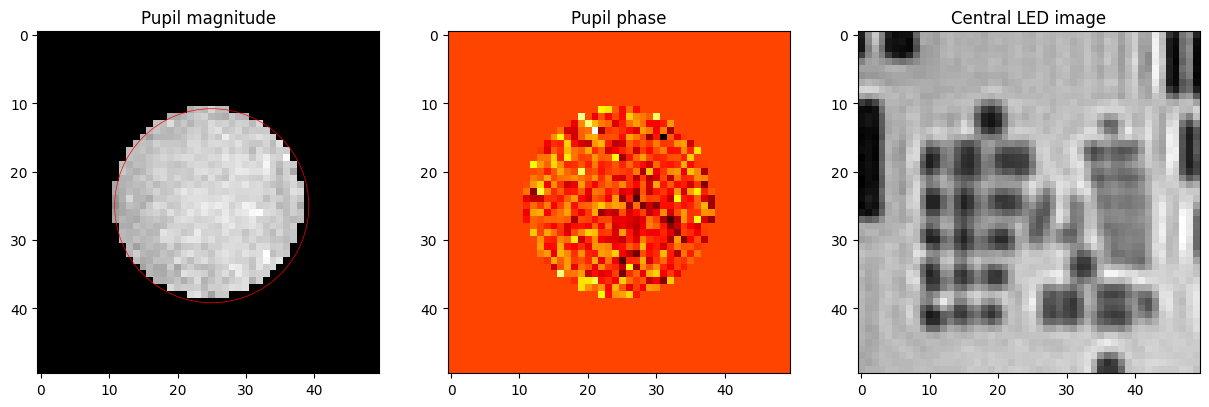

In [11]:
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15,15))

# Recovered object
obj_mag = np.abs(rec_obj) # Magnitude
obj_arg = np.angle(rec_obj) # Phase

# Recovered pupil
pupil_mag = np.abs(rec_pupil)
pupil_arg = np.angle(rec_pupil)

# # Show object
# axes[0].imshow(obj_mag,cmap='gray')
# axes[0].set_title('Object magnitude')
# axes[1].imshow(obj_arg, cmap='gray') # Heatmap for phase information
# axes[1].set_title('Object phase')

# Show pupil
axes[0].imshow(pupil_mag,cmap='gray')
axes[0].set_title('Pupil magnitude')
axes[1].imshow(pupil_arg, cmap='hot') # Heatmap for phase information
axes[1].set_title('Pupil phase')
circle = patches.Circle((img_size//2,img_size//2),radius=pupil_radius,linewidth =0.5, edgecolor='red',facecolor='none')
axes[0].add_patch(circle) # Ensure pupil radius is correct

# Show central image
axes[2].imshow(images[:,:,0], cmap='gray')
axes[2].set_title('Central LED image')

# Save results (object)
obj_mag = obj_mag / np.max(obj_mag) # Normalise
obj_mag = (obj_mag * 255).astype(np.uint8)
obj_mag = Image.fromarray(obj_mag)
obj_mag.save('results/recent/magnitude.png')

obj_arg = plt.cm.hot(obj_arg)  # Necessary for saving image
obj_arg = (obj_arg * 255).astype(np.uint8)
obj_arg = Image.fromarray(obj_arg)
obj_arg.save('results/recent/phase.png',format='PNG')

img_0 = images[:,:,0] / np.max(images[:,:,0])
img_0 = (img_0 * 255).astype(np.uint8)
img_0 = Image.fromarray(img_0)
img_0.save('results/recent/brightfield.png',format='PNG')


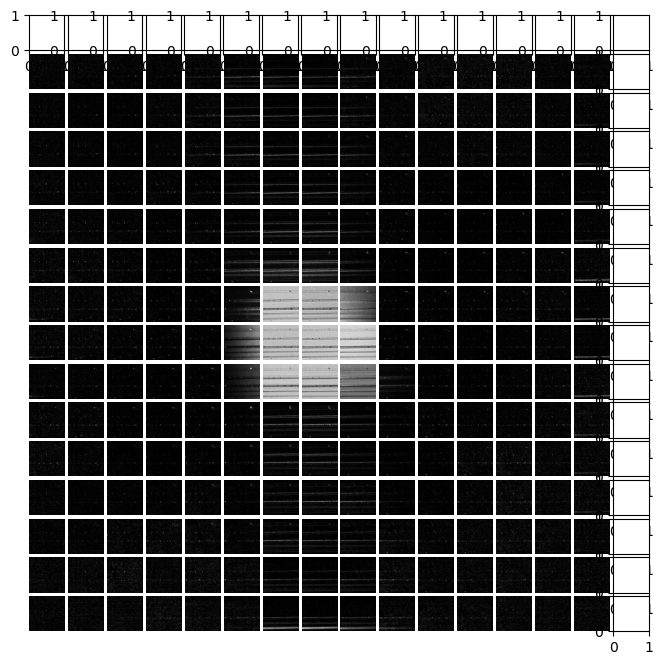

In [35]:
import matplotlib.pyplot as plt
import fpm_functions as fpm 
from PIL import Image
import os
import numpy as np

grid_size = 15
data_folder = 'data/recent'
x,y = fpm.LED_spiral(grid_size) # Get the coordinates of LEDs

fig, axes = plt.subplots(16, 16, figsize=(8,8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(grid_size*grid_size):
    image = np.array(Image.open(os.path.join(data_folder,f'image_{i}.png')))
    # imgage = cv2.fastNlMeansDenoising(image,None,1,7,21)
    # image = images[:,:,i] # For viewing matlab data (run above block first)
    # print(np.max(image),np.min(image))
    row = -y[i]-1
    col = x[i]
    # print(row,col)
    axes[row,col].imshow(image, cmap='gray')
    axes[row,col].axis('off') 

plt.savefig('data/data_grids/recent.png')